In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import datetime as dt
import math, copy, time, os
from kaggle.competitions import nflrush
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import tensorflow.compat.v1 as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')
tf.disable_v2_behavior()
import os
__print__ = print
def print(string):
    os.system(f'echo \"{string}\"')
    __print__(string)

In [2]:
# Import data
df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2020/train.csv', low_memory=False)
shape = str(df.shape)
print(df.columns)
print(df.shape)

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'Yards', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')
(509762, 49)


In [3]:
def prepare_data(df):
    # Clean columns with missing values
    df.loc[df['StadiumType'].isnull(), 'StadiumType'] = 'Unknown'
    df.loc[df['GameWeather'].isnull(), 'GameWeather'] = 'Unknown'
    df.loc[df['WindDirection'].isnull(), 'WindDirection'] = 'Unknown'
    df.loc[df['WindSpeed'].isnull(), 'WindSpeed'] = '0'
    df.loc[df['Orientation'].isnull(), 'Orientation'] = 0
    df.loc[df['Dir'].isnull(), 'Dir'] = 0
    df.loc[df['GameWeather']== 'T: 51; H: 55; W: NW 10 mph', 'Temperature'] = 51
    df.loc[df['GameWeather']== 'T: 51; H: 55; W: NW 10 mph', 'WindDirection'] = 'NW 10 mph'
    df.loc[df['GameWeather']== 'T: 51; H: 55; W: NW 10 mph', 'Humidity'] = 55
    df.loc[df['Temperature'].isnull(), 'Temperature'] = 70
    df.loc[df['Humidity'].isnull(), 'Humidity'] = 0
    df.loc[df['OffenseFormation'].isnull(), 'OffenseFormation'] = 'Unknown'
    
    df.loc[df['PossessionTeam'] == df['HomeTeamAbbr'] , 'DefendingTeam'] = df['VisitorTeamAbbr']
    df.loc[df['PossessionTeam'] != df['HomeTeamAbbr'] , 'DefendingTeam'] = df['HomeTeamAbbr']

    df.loc[(df['FieldPosition'].isnull()) & (df['PlayDirection'] == 'right') & (df['X'] >= 50), 'FieldPosition'] = df['DefendingTeam']
    df.loc[(df['FieldPosition'].isnull()) & (df['PlayDirection'] == 'right') & (df['X'] < 50), 'FieldPosition'] = df['PossessionTeam']
    df.loc[(df['FieldPosition'].isnull()) & (df['PlayDirection'] == 'left') & (df['X'] >= 50), 'FieldPosition'] = df['PossessionTeam']
    df.loc[(df['FieldPosition'].isnull()) & (df['PlayDirection'] == 'left') & (df['X'] < 50), 'FieldPosition'] = df['DefendingTeam']
    
    # Drop remaining missing values
    df = df.dropna()
    
    # Data Cleansing WindSpeed
    df['WindSpeed'] = df['WindSpeed'].astype('str')

    #df['WindSpeed'].str.strip().unique()
    df['WindSpeed'] = df['WindSpeed'].str.replace('mph', '')
    df['WindSpeed'] = df['WindSpeed'].str.replace('Mph', '')
    df['WindSpeed'] = df['WindSpeed'].str.replace('MPH', '')
    df['WindSpeed'] = df['WindSpeed'].str.replace('MPh', '')
    df['WindSpeed'] = df['WindSpeed'].str.strip()

    b = df['WindSpeed'].loc[df['WindSpeed'].str.contains('-', regex=False)==True].unique()

    b1 = df['WindSpeed'].loc[df['WindSpeed'].str.contains('-', regex=False)==True].str[:2]
    b2 = df['WindSpeed'].loc[df['WindSpeed'].str.contains('-', regex=False)==True].str[-2:]
    b3 = (b1.astype('float64') + b2.astype('float64')) / 2


    for i in b:
        df.loc[(df.WindSpeed == i), 'WindSpeed'] = b3

    v = df[df['WindSpeed'].str.isnumeric() == False]
    av = v['WindSpeed'].unique()

    for j in av:
        df.loc[(df.WindSpeed == j), 'WindSpeed'] = '0.0'

    df['WindSpeed'] = df['WindSpeed'].astype('float64')
    
    # Adjust X coordinates and orientation features
    df.X[df['PlayDirection'] == 'left'] = 120 - df['X']

    df.YardLine[df['PossessionTeam'] == df['FieldPosition']] = 10 + df['YardLine']
    df.YardLine[df['PossessionTeam'] != df['FieldPosition']] = 60.0 + (50 - df['YardLine'])

    df.Orientation[df['PlayDirection'] == 'left'] = 360 - df['Orientation']
    df.loc[(df['PlayDirection'] == 'left') & (df['Orientation'] == 0) ,'Orientation'] = 0

    df.Orientation[df['PlayDirection'] == 'left'] = 360 - df['Dir']
    df.loc[(df['PlayDirection'] == 'left') & (df['Dir'] == 0) ,'Dir'] = 0
    
    # create nfl team abbreviation dictionary
    nfl = {
    1:	'ARI',
    2:	'ATL',
    3:	'BAL',
    4:	'BUF',
    5:	'CAR',
    6:	'CHI',
    7:	'CIN',
    8:	'CLE',
    9:	'DAL',
    10:	'DEN',
    11:	'DET',
    12:	'GB',
    13:	'HOU',
    14:	'IND',
    15:	'JAX',
    16:	'KC',
    17:	'LAC',
    18:	'LAR',
    19:	'MIA',
    20:	'MIN',
    21:	'NE',
    22:	'NO',
    23:	'NYG',
    24:	'NYJ',
    25:	'OAK',
    26:	'PHI',
    27:	'PIT',
    28:	'SEA',
    29:	'SF',
    30:	'TB',
    31:	'TEN',
    32:	'WAS'
    }

    nfl_teams = pd.DataFrame.from_dict(nfl, orient='index')
    nfl_teams['team_id'] = nfl_teams.index
    nfl_teams = nfl_teams.rename(columns={0: 'team_abb'})

	# Replace HomeTeamAbbr and VisitorTeamAbbr by ids
    df.loc[df['HomeTeamAbbr'] == 'ARZ', 'HomeTeamAbbr'] = 'ARI'
    df.loc[df['HomeTeamAbbr'] == 'BLT', 'HomeTeamAbbr'] = 'BAL'
    df.loc[df['HomeTeamAbbr'] == 'CLV', 'HomeTeamAbbr'] = 'CLE'
    df.loc[df['HomeTeamAbbr'] == 'HST', 'HomeTeamAbbr'] = 'HOU'
    df.loc[df['HomeTeamAbbr'] == 'LA', 'HomeTeamAbbr'] = 'LAR'

    df.loc[df['VisitorTeamAbbr'] == 'ARZ', 'VisitorTeamAbbr'] = 'ARI'
    df.loc[df['VisitorTeamAbbr'] == 'BLT', 'VisitorTeamAbbr'] = 'BAL'
    df.loc[df['VisitorTeamAbbr'] == 'CLV', 'VisitorTeamAbbr'] = 'CLE'
    df.loc[df['VisitorTeamAbbr'] == 'HST', 'VisitorTeamAbbr'] = 'HOU'
    df.loc[df['VisitorTeamAbbr'] == 'LA', 'VisitorTeamAbbr'] = 'LAR'

    df = df.merge(nfl_teams, left_on ='HomeTeamAbbr', right_on ='team_abb', how = 'left')
    df = df.drop(['HomeTeamAbbr','team_abb'], axis=1)
    df = df.rename(columns={'team_id': 'HomeTeamAbbr'})

    df = df.merge(nfl_teams, left_on ='VisitorTeamAbbr', right_on ='team_abb', how = 'left')
    df = df.drop(['VisitorTeamAbbr','team_abb'], axis=1)
    df = df.rename(columns={'team_id': 'VisitorTeamAbbr'})

    df['HomeTeamAbbr'] = df['HomeTeamAbbr'].astype('float64')
    df['VisitorTeamAbbr'] = df['VisitorTeamAbbr'].astype('float64')

    
	# Replace FieldPosition and PossessionTeam by ids
    df.loc[df['FieldPosition'] == 'ARZ', 'FieldPosition'] = 'ARI'
    df.loc[df['FieldPosition'] == 'BLT', 'FieldPosition'] = 'BAL'
    df.loc[df['FieldPosition'] == 'CLV', 'FieldPosition'] = 'CLE'
    df.loc[df['FieldPosition'] == 'HST', 'FieldPosition'] = 'HOU'
    df.loc[df['FieldPosition'] == 'LA', 'FieldPosition'] = 'LAR'

    df.loc[df['PossessionTeam'] == 'ARZ', 'PossessionTeam'] = 'ARI'
    df.loc[df['PossessionTeam'] == 'BLT', 'PossessionTeam'] = 'BAL'
    df.loc[df['PossessionTeam'] == 'CLV', 'PossessionTeam'] = 'CLE'
    df.loc[df['PossessionTeam'] == 'HST', 'PossessionTeam'] = 'HOU'
    df.loc[df['PossessionTeam'] == 'LA', 'PossessionTeam'] = 'LAR'

    df = df.merge(nfl_teams, left_on ='FieldPosition', right_on ='team_abb', how = 'left')
    df = df.drop(['FieldPosition','team_abb'], axis=1)
    df = df.rename(columns={'team_id': 'FieldPosition'})


    df = df.merge(nfl_teams, left_on ='PossessionTeam', right_on ='team_abb', how = 'left')
    df = df.drop(['PossessionTeam','team_abb'], axis=1)
    df = df.rename(columns={'team_id': 'PossessionTeam'})

    df['FieldPosition'] = df['FieldPosition'].astype('float64')
    df['PossessionTeam'] = df['PossessionTeam'].astype('float64')    
    
    
	# Create Defense features
    df['DefensePersonnel_DL'] = df['DefensePersonnel'].str.replace(', ', '_').str.replace(' ', '').str.slice(0, 1)
    df['DefensePersonnel_LB'] = df['DefensePersonnel'].str.replace(', ', '_').str.replace(' ', '').str.slice(4, 5)
    df['DefensePersonnel_DB'] = df['DefensePersonnel'].str.replace(', ', '_').str.replace(' ', '').str.slice(8, 9)

    df['DefensePersonnel_DL'] = df['DefensePersonnel_DL'].astype('int64')
    df['DefensePersonnel_LB'] = df['DefensePersonnel_LB'].astype('int64')
    df['DefensePersonnel_DB'] = df['DefensePersonnel_DB'].astype('int64')

	# Create Offense features
    df.loc[df['OffensePersonnel'].str.replace(', ', '_').str.replace(' ', '').str.slice(1, 3) == 'OL', 'OffensePersonnel_Flag'] = 1
    df.loc[df['OffensePersonnel'].str.replace(', ', '_').str.replace(' ', '').str.slice(1, 3) == 'QB', 'OffensePersonnel_Flag'] = 2
    df.loc[df['OffensePersonnel'].str.replace(', ', '_').str.replace(' ', '').str.slice(1, 3) == 'RB', 'OffensePersonnel_Flag'] = 0

	# with QB
    df.loc[df['OffensePersonnel_Flag'] == 2, 'OffensePersonnel_QB'] = df['OffensePersonnel'].str.replace(', ', '_').str.replace(' ', '').str.slice(0, 1)
    df.loc[df['OffensePersonnel_Flag'] == 2, 'OffensePersonnel_RB'] = df['OffensePersonnel'].str.replace(', ', '_').str.replace(' ', '').str.slice(4, 5)
    df.loc[df['OffensePersonnel_Flag'] == 2, 'OffensePersonnel_TE'] = df['OffensePersonnel'].str.replace(', ', '_').str.replace(' ', '').str.slice(8, 9)
    df.loc[df['OffensePersonnel_Flag'] == 2, 'OffensePersonnel_WR'] = df['OffensePersonnel'].str.replace(', ', '_').str.replace(' ', '').str.slice(12, 13)
    df.loc[df['OffensePersonnel_Flag'] != 2, 'OffensePersonnel_QB'] = '1'

	# with OL
    df.loc[df['OffensePersonnel_Flag'] == 1, 'OffensePersonnel_OL'] = df['OffensePersonnel'].str.replace(', ', '_').str.replace(' ', '').str.slice(0, 1)
    df.loc[df['OffensePersonnel_Flag'] == 1, 'OffensePersonnel_RB'] = df['OffensePersonnel'].str.replace(', ', '_').str.replace(' ', '').str.slice(4, 5)
    df.loc[df['OffensePersonnel_Flag'] == 1, 'OffensePersonnel_TE'] = df['OffensePersonnel'].str.replace(', ', '_').str.replace(' ', '').str.slice(8, 9)
    df.loc[df['OffensePersonnel_Flag'] == 1, 'OffensePersonnel_WR'] = df['OffensePersonnel'].str.replace(', ', '_').str.replace(' ', '').str.slice(12, 13)

	# without OL and without QB
    df.loc[df['OffensePersonnel_Flag'] == 0, 'OffensePersonnel_RB'] = df['OffensePersonnel'].str.replace(', ', '_').str.replace(' ', '').str.slice(0, 1)
    df.loc[df['OffensePersonnel_Flag'] == 0, 'OffensePersonnel_TE'] = df['OffensePersonnel'].str.replace(', ', '_').str.replace(' ', '').str.slice(4, 5)
    df.loc[df['OffensePersonnel_Flag'] == 0, 'OffensePersonnel_WR'] = df['OffensePersonnel'].str.replace(', ', '_').str.replace(' ', '').str.slice(8, 9)

	#calculate OL for cases without
    df['OffensePersonnel_QB'] = df['OffensePersonnel_QB'].astype('int64')
    df['OffensePersonnel_RB'] = df['OffensePersonnel_RB'].astype('int64')
    df['OffensePersonnel_TE'] = df['OffensePersonnel_TE'].astype('int64')
    df['OffensePersonnel_WR'] = df['OffensePersonnel_WR'].astype('int64')

    df.loc[df['OffensePersonnel_Flag'] != 1, 'OffensePersonnel_OL_tmp'] = 11 - (df['OffensePersonnel_RB'] + df['OffensePersonnel_TE'] + df['OffensePersonnel_WR']+df['OffensePersonnel_QB'])
    df.loc[df['OffensePersonnel_Flag'] != 1, 'OffensePersonnel_OL'] = df['OffensePersonnel_OL_tmp']
    df['OffensePersonnel_OL'] = df['OffensePersonnel_OL'].astype('int64')
    df = df.drop(['OffensePersonnel_OL_tmp'], axis=1)    
       

	# Convert height to meters
	#1 ft = 0.3048 m
	#1 in = 0.0254 m

    PlayerHeight_ft=df['PlayerHeight'].str.split('-').str[0].astype('float64')
    PlayerHeight_in=df['PlayerHeight'].str.split('-').str[1].astype('float64')
    PlayerHeight_m = PlayerHeight_ft*0.3048 + PlayerHeight_in*0.0254

    df['PlayerHeight'] = PlayerHeight_m.astype('float64')

	# Convert date time columns
    time_snap_handoff = pd.to_datetime(df['TimeHandoff']) - pd.to_datetime(df['TimeSnap'])
    time_snap_handoff_sec = pd.to_timedelta(time_snap_handoff)
    df['TimeSnapHandoff'] = time_snap_handoff_sec.dt.seconds.astype('int64')

    df['GameYear'] = pd.DatetimeIndex(df['TimeSnap']).year
    df['GameMonth'] = pd.DatetimeIndex(df['TimeSnap']).month
    df['GameDay'] = pd.DatetimeIndex(df['TimeSnap']).day

    today=dt.datetime.today().strftime('%Y-%m-%d')
    today=pd.to_datetime(today)
    PlayerAgeDays = today - pd.to_datetime(df['PlayerBirthDate'])
    df['PlayerAgeYears'] = PlayerAgeDays/np.timedelta64(1,'Y')

    GameClockMin = pd.DatetimeIndex(df['GameClock']).hour
    GameClockSec = pd.DatetimeIndex(df['GameClock']).minute
    df['GameClockSeconds'] = GameClockMin*60 + GameClockSec
     
    # Drop unnecessary columns
    columns_to_drop = ['GameClock','TimeSnap','TimeHandoff','PlayerBirthDate', 'JerseyNumber',
    'OffensePersonnel', 'DefensePersonnel','PlayerCollegeName']
    df = df.drop(columns_to_drop, axis=1)
    df.columns
    return df

In [4]:
def transform_data(df):
    # Categorical boolean mask
    categorical_feature_mask = df.dtypes==object

    # filter categorical columns using mask and turn it into a list
    categorical_cols = df.columns[categorical_feature_mask].tolist()
    #cols_to_remove = ['GameClock','TimeHandoff','TimeSnap']
    #for i in cols_to_remove:
    #    categorical_cols.remove(i)
    print(categorical_cols)

    # Encode categorical features
    le = LabelEncoder()

    # apply le on categorical feature columns
    df[categorical_cols] = df[categorical_cols].apply(lambda col: le.fit_transform(col))
    
    col_names = ['X', 'Y', 'S', 'A', 'Dis', 'Orientation', 'Dir', 'YardLine',  'Distance',
       'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'DefendersInTheBox', 'PlayerHeight', 'PlayerWeight', 'Temperature', 'Humidity', 'WindSpeed',
       'DefensePersonnel_DL', 'DefensePersonnel_LB', 'DefensePersonnel_DB',
       'OffensePersonnel_Flag', 'OffensePersonnel_QB', 'OffensePersonnel_RB',
       'OffensePersonnel_TE', 'OffensePersonnel_WR', 'OffensePersonnel_OL',
       'TimeSnapHandoff',  'PlayerAgeYears','GameClockSeconds']
    
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features 
    return df

In [5]:
dfa = prepare_data(df)

In [6]:
dfa_sc = transform_data(dfa)

['Team', 'DisplayName', 'OffenseFormation', 'PlayDirection', 'Position', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather', 'WindDirection', 'DefendingTeam']


In [7]:
# Split data into y and X
feature_names = ['Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation', 'Dir', 'NflId',
       'Season', 'YardLine', 'Quarter', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'DefendersInTheBox', 'PlayDirection',
       'PlayerHeight', 'PlayerWeight', 'Position', 'HomeTeamAbbr',
       'VisitorTeamAbbr', 'Week', 'Stadium', 'Location', 'StadiumType', 'Turf',
       'GameWeather', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection',
       'DefensePersonnel_DL', 'DefensePersonnel_LB', 'DefensePersonnel_DB',
       'OffensePersonnel_Flag', 'OffensePersonnel_QB', 'OffensePersonnel_RB',
       'OffensePersonnel_TE', 'OffensePersonnel_WR', 'OffensePersonnel_OL',
       'TimeSnapHandoff', 'GameYear', 'GameMonth', 'GameDay', 'PlayerAgeYears',
       'GameClockSeconds']

dfy = dfa_sc[['Yards']]
dfX = dfa_sc[feature_names]
yards = dfy.Yards

y = np.zeros((yards.shape[0], 199))
for idx, target in enumerate(list(yards)):
    y[idx][99 + target] = 1

In [8]:
# Split X and y into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(dfX, y, test_size=0.33, random_state = 8)
X_train.shape,y_train.shape, X_test.shape, y_test.shape

((341496, 52), (341496, 199), (168200, 52), (168200, 199))

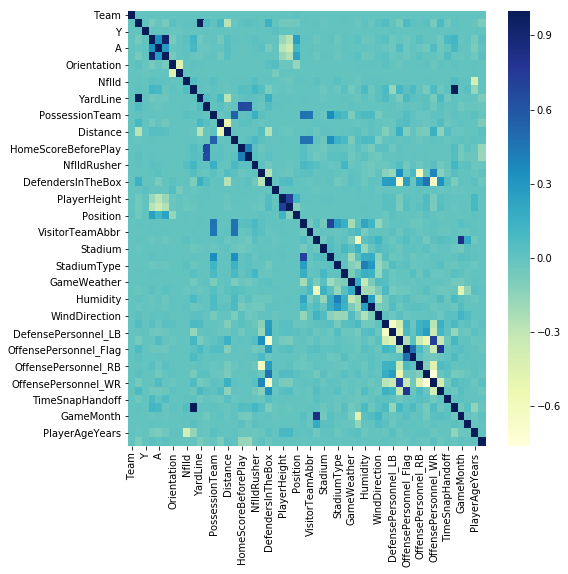

In [9]:
# Plot correlation matrix
correlation_matrix = dfX.corr()
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='YlGnBu')

In [10]:
# Function to check model accuracy
def crps(y_true, y_pred):
    y_true = np.clip(np.cumsum(y_true, axis=1), 0, 1)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
    return ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * y_true.shape[0]) 

In [11]:
# Build Neural Network
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(199, activation='softmax')
    ])


    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

In [12]:
model = build_model()

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                3392      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 199)               12935     
Total params: 20,999
Trainable params: 20,743
Non-trainable params: 256
_________________________________________________________________


In [14]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [15]:
history = model.fit(X_train,
                    y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    callbacks=[early_stop])

Train on 341496 samples, validate on 168200 samples
Epoch 1/40
341496/341496 [==============================] - 13s 37us/sample - loss: 0.0219 - acc: 0.9950 - val_loss: 0.0194 - val_acc: 0.9950
Epoch 2/40
341496/341496 [==============================] - 12s 35us/sample - loss: 0.0193 - acc: 0.9950 - val_loss: 0.0195 - val_acc: 0.9950
Epoch 3/40
341496/341496 [==============================] - 12s 34us/sample - loss: 0.0193 - acc: 0.9950 - val_loss: 0.0194 - val_acc: 0.9950
Epoch 4/40
341496/341496 [==============================] - 12s 34us/sample - loss: 0.0193 - acc: 0.9950 - val_loss: 0.0195 - val_acc: 0.9950
Epoch 5/40
341496/341496 [==============================] - 12s 35us/sample - loss: 0.0193 - acc: 0.9950 - val_loss: 0.0196 - val_acc: 0.9950
Epoch 6/40
341496/341496 [==============================] - 12s 34us/sample - loss: 0.0193 - acc: 0.9950 - val_loss: 0.0193 - val_acc: 0.9950
Epoch 7/40
341496/341496 [==============================] - 12s 35us/sample - loss: 0.0193 - acc

In [16]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,acc,val_loss,val_acc,epoch
28,0.01926,0.994976,0.019729,0.994974,28
29,0.01926,0.994976,0.019319,0.994974,29
30,0.01926,0.994976,0.023408,0.994974,30
31,0.01926,0.994976,0.019649,0.994974,31
32,0.01926,0.994976,0.019421,0.994974,32


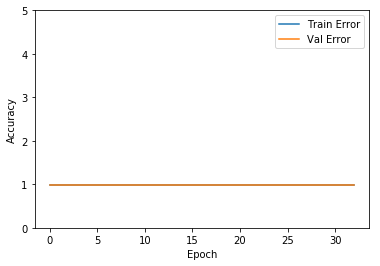

In [17]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['acc'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_acc'],
           label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

plot_history(history)

In [18]:
test_predictions = model.predict(X_test)

In [19]:
accuracy = crps(y_test, test_predictions)
print(accuracy)

0.014488775818122683


In [20]:
# Submit results
env = nflrush.make_env()
for (test_df, sample_prediction_df) in env.iter_test():     
    dfb = prepare_data(test_df)
    feature_names = ['Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation', 'Dir', 'NflId',
       'Season', 'YardLine', 'Quarter', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'DefendersInTheBox', 'PlayDirection',
       'PlayerHeight', 'PlayerWeight', 'Position', 'HomeTeamAbbr',
       'VisitorTeamAbbr', 'Week', 'Stadium', 'Location', 'StadiumType', 'Turf',
       'GameWeather', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection',
       'DefensePersonnel_DL', 'DefensePersonnel_LB', 'DefensePersonnel_DB',
       'OffensePersonnel_Flag', 'OffensePersonnel_QB', 'OffensePersonnel_RB',
       'OffensePersonnel_TE', 'OffensePersonnel_WR', 'OffensePersonnel_OL',
       'TimeSnapHandoff', 'GameYear', 'GameMonth', 'GameDay', 'PlayerAgeYears',
       'GameClockSeconds']


    dfb_sc = transform_data(dfb)

    dfb_sc_final = dfb[feature_names]


    y_pred = np.mean([model.predict(dfb_sc_final)],axis=0)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1).tolist()[0]
    
    preds_df = pd.DataFrame(data=[y_pred], columns=sample_prediction_df.columns)
    env.predict(preds_df)
    
env.write_submission_file()

['Team', 'DisplayName', 'OffenseFormation', 'PlayDirection', 'Position', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather', 'WindDirection', 'DefendingTeam']
['Team', 'DisplayName', 'OffenseFormation', 'PlayDirection', 'Position', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather', 'WindDirection', 'DefendingTeam']
['Team', 'DisplayName', 'OffenseFormation', 'PlayDirection', 'Position', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather', 'WindDirection', 'DefendingTeam']
['Team', 'DisplayName', 'OffenseFormation', 'PlayDirection', 'Position', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather', 'WindDirection', 'DefendingTeam']
['Team', 'DisplayName', 'OffenseFormation', 'PlayDirection', 'Position', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather', 'WindDirection', 'DefendingTeam']
['Team', 'DisplayName', 'OffenseFormation', 'PlayDirection', 'Position', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather', 'WindDirection', 'Defendin